# Underwater Acoustic Ray Tracing in the SOFAR(Sound Fixing and Ranging) Channel using Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from tqdm import tqdm

from IPython.display import HTML, display, Image
from matplotlib import animation

In [3]:
# SPEED_OF_SOUND_SURFACE = 1480  # meters / second
SOUND_SPEED_MIN = 1480
SOUND_SPEED_MAX = 1550

DEPTH_MIN = 0  # Ocean Surface
DEPTH_MAX = 5500  # meters
DEPTH_MIN_SPEED = 1100 # depth where minimum speed of sound is observed
DEPTH_RANGE = np.arange(DEPTH_MIN, DEPTH_MAX + 1)

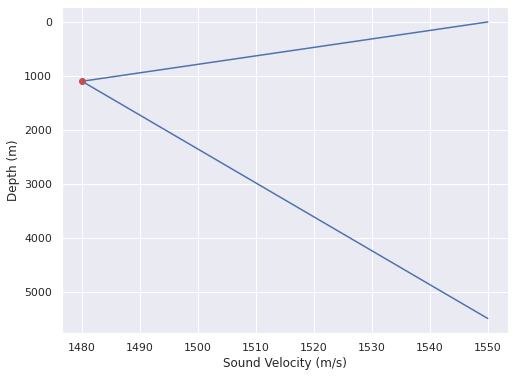

In [4]:
SOUND_GRADIENT_SHALLOW = (SOUND_SPEED_MIN - SOUND_SPEED_MAX) / (DEPTH_MIN_SPEED - DEPTH_MIN)
SOUND_GRADIENT_DEEP = (SOUND_SPEED_MAX - SOUND_SPEED_MIN) / (DEPTH_MAX - DEPTH_MIN_SPEED)

# vectorize the sound gradients
# sound velocity gradient up to 1100 meters deep
sound_grad_shallow_vec  = np.full(
    (1, np.argwhere(DEPTH_RANGE == DEPTH_MIN_SPEED)[0][0]),
    SOUND_GRADIENT_SHALLOW
)
# sound velocity gradient beyond 1100 meters
sound_grad_deep_vec = np.full(
    (1, np.argmax(DEPTH_RANGE) - np.argwhere(DEPTH_RANGE == DEPTH_MIN_SPEED)[0][0]),
    SOUND_GRADIENT_DEEP
)

# construct the sound velocity profile
sound_velocity_profile = SOUND_SPEED_MIN + \
                            (DEPTH_RANGE[:-1] - DEPTH_MIN_SPEED) * \
                            np.append(sound_grad_shallow_vec, sound_grad_deep_vec)

# plot the sound velocity profile
fig = plt.figure(figsize=(8,6))
plt.plot(sound_velocity_profile, DEPTH_RANGE[:-1])
plt.plot([SOUND_SPEED_MIN],[DEPTH_MIN_SPEED], 'ro')
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.xlabel('Sound Velocity (m/s)')
plt.show()

In [8]:
SOURCE_DEPTH = DEPTH_MIN_SPEED
SOURCE_SOUND_SPEED = SOUND_SPEED_MIN
TRANSMISSION_ANGLE_RANGE = np.deg2rad(np.arange(-40, 50, 1))  # angle of transmission in rad
angle_0_ind = np.argwhere(TRANSMISSION_ANGLE_RANGE == 0)[0][0]  # index of the 0 degree mark

In [10]:
SIMULATION_STEPS = 1000  # meters
SIMULATION_RANGE = np.arange(0, 200e3 + SIMULATION_STEPS, SIMULATION_STEPS)

In [11]:
# Instantiate our matrices
R = np.zeros((len(TRANSMISSION_ANGLE_RANGE), len(SIMULATION_RANGE)))
z = np.zeros_like(R)
c = np.zeros_like(R)
theta = np.zeros_like(R)

# Prime the initial conditions
z[:, 0] = DEPTH_MIN_SPEED  # we put the source at the depth of min sound speed
R[:, 0] = -SOURCE_SOUND_SPEED / np.append(
    SOUND_GRADIENT_SHALLOW * np.cos(TRANSMISSION_ANGLE_RANGE[:angle_0_ind+1]),
    SOUND_GRADIENT_DEEP * np.cos(TRANSMISSION_ANGLE_RANGE[angle_0_ind+1:]),
)
c[:, 0] = SOUND_SPEED_MIN
theta[:, 0] = TRANSMISSION_ANGLE_RANGE

In [12]:
for j in tqdm(range(1, len(SIMULATION_RANGE))):
    for i in range(0, len(TRANSMISSION_ANGLE_RANGE)):
        
        if (z[i, j-1] == SOURCE_DEPTH) and (theta[i, j-1] == 0):
            c[i, j] = SOURCE_SOUND_SPEED
            theta[i, j] = 0
            dz = 0
            z[i, j] = SOURCE_DEPTH
            
        elif (z[i, j-1] < SOURCE_DEPTH) or (z[i, j-1] == SOURCE_DEPTH and theta[i, j-1] > 0):
            R[i, j] = -c[i, j-1] / (SOUND_GRADIENT_SHALLOW * np.cos(theta[i ,j-1]))
            theta[i, j] = np.arcsin(
                SIMULATION_STEPS / R[i, j-1] + np.sin(theta[i, j-1])
            )
            dz = R[i, j-1] * (np.cos(theta[i, j-1]) - np.cos(theta[i, j]))
            z[i, j] = z[i, j-1] + dz
            c[i, j] = SOURCE_SOUND_SPEED + SOUND_GRADIENT_SHALLOW * (z[i, j] - SOURCE_DEPTH)
            
        elif (z[i, j-1] > SOURCE_DEPTH) or (z[i, j-1] == SOURCE_DEPTH and theta[i, j-1] < 0):
            R[i, j] = -c[i, j-1] / (SOUND_GRADIENT_DEEP * np.cos(theta[i ,j-1]))
            theta[i, j] = np.arcsin(
                SIMULATION_STEPS / R[i, j-1] + np.sin(theta[i, j-1])
            )
            dz = R[i, j-1] * (np.cos(theta[i, j-1]) - np.cos(theta[i, j]))
            z[i, j] = z[i, j-1] + dz
            c[i, j] = SOURCE_SOUND_SPEED + SOUND_GRADIENT_DEEP * (z[i, j] - SOURCE_DEPTH)


100%|██████████| 200/200 [00:00<00:00, 786.33it/s]


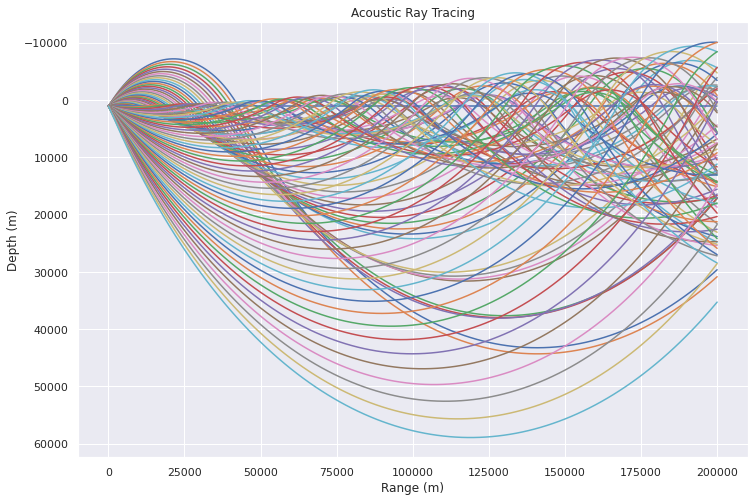

In [13]:
plt.figure(figsize=(12,8))
for i in range(0, len(TRANSMISSION_ANGLE_RANGE)):
    plt.plot(SIMULATION_RANGE, z[i])
plt.gca().invert_yaxis()
plt.title('Acoustic Ray Tracing')
plt.xlabel('Range (m)')
plt.ylabel('Depth (m)')
plt.show()

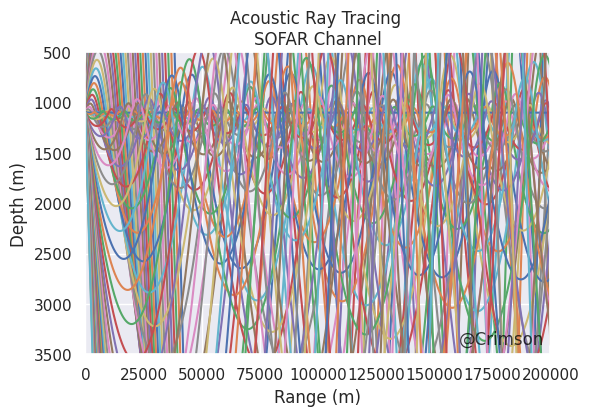

In [27]:
duration_sec = 2
dpi = 100
bitrate = 100


fig, ax = plt.subplots(dpi=dpi)
fig.text(0.89, 0.14, '@Crimson',
             fontsize=12, color='black',
             ha='right', va='bottom', alpha=0.75)
fps = len(SIMULATION_RANGE) // duration_sec

GifWriter = animation.ImageMagickFileWriter(fps,
                                             bitrate=bitrate
                                             )
# save_filename = 'SOFAR_ray_trace.gif'
# with GifWriter.saving(fig, save_filename, dpi=dpi):
# plt.figure(figsize = (15,8))
for i in range(0, len(SIMULATION_RANGE) + 75, 75):
    plt.cla()
    ax.set_xlim(0, SIMULATION_RANGE[-1])
    ax.set_ylim(500, 3500)
    ax.set_title(f"Acoustic Ray Tracing \nSOFAR Channel")
    plt.gca().invert_yaxis()
    plt.xlabel('Range (m)')
    plt.ylabel('Depth (m)')
    for a in range(0, len(TRANSMISSION_ANGLE_RANGE)):
        ax.plot(SIMULATION_RANGE[:i], z[a,:i])
        # GifWriter.grab_frame()
plt.show()
plt.close()

![SegmentLocal](SOFAR_ray_trace.gif "segment")

100%|██████████| 10000/10000 [00:11<00:00, 865.80it/s]


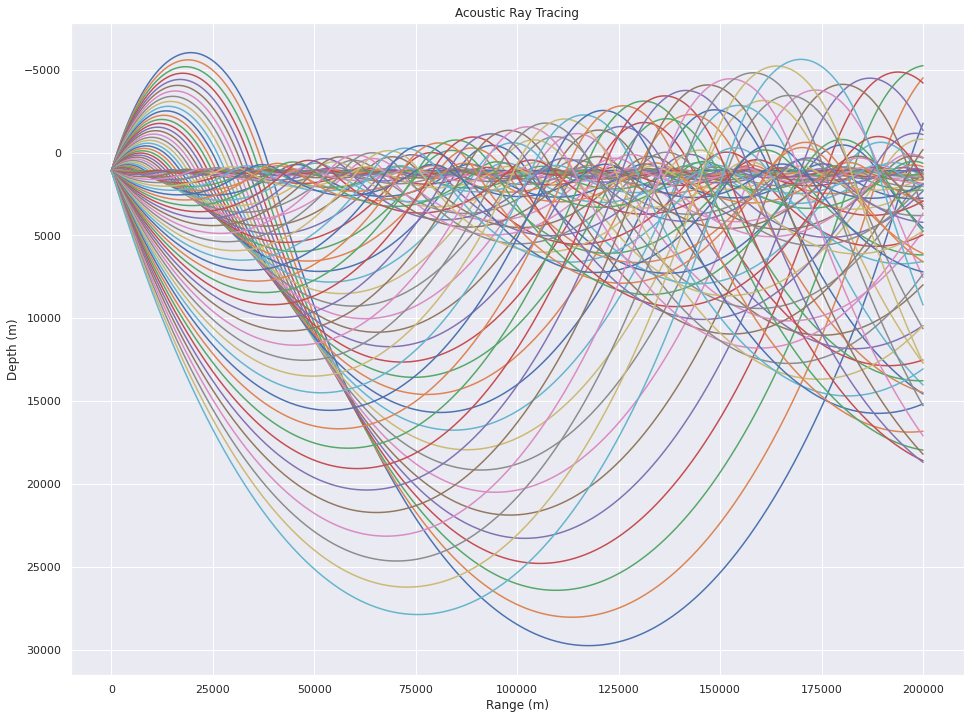

In [25]:

SOURCE_DEPTH = DEPTH_MIN_SPEED
SOURCE_SOUND_SPEED = SOUND_SPEED_MIN
TRANSMISSION_ANGLE_RANGE = np.deg2rad(np.arange(-40, 40, 1))  # angle of transmission in rad -20 to 20
angle_0_ind = np.argwhere(TRANSMISSION_ANGLE_RANGE == 0)[0][0]  # index of the 0 degree mark

SIMULATION_STEPS = 20  # meters
SIMULATION_RANGE = np.arange(0, 200e3 + SIMULATION_STEPS, SIMULATION_STEPS)

# Instantiate our matrices
R = np.zeros((len(TRANSMISSION_ANGLE_RANGE), len(SIMULATION_RANGE)))
z = np.zeros_like(R)
c = np.zeros_like(R)
theta = np.zeros_like(R)

# Prime the initial conditions
z[:, 0] = DEPTH_MIN_SPEED  # we put the source at the depth of min sound speed
R[:, 0] = -SOURCE_SOUND_SPEED / np.append(
    SOUND_GRADIENT_SHALLOW * np.cos(TRANSMISSION_ANGLE_RANGE[:angle_0_ind+1]),
    SOUND_GRADIENT_DEEP * np.cos(TRANSMISSION_ANGLE_RANGE[angle_0_ind+1:]),
)
c[:, 0] = SOUND_SPEED_MIN
theta[:, 0] = TRANSMISSION_ANGLE_RANGE

for j in tqdm(range(1, len(SIMULATION_RANGE))):
    for i in range(0, len(TRANSMISSION_ANGLE_RANGE)):
        
        if (z[i, j-1] == SOURCE_DEPTH) and (theta[i, j-1] == 0):
            c[i, j] = SOURCE_SOUND_SPEED
            theta[i, j] = 0
            dz = 0
            z[i, j] = SOURCE_DEPTH
            
        elif (z[i, j-1] < SOURCE_DEPTH) or (z[i, j-1] == SOURCE_DEPTH and theta[i, j-1] > 0):
            R[i, j] = -c[i, j-1] / (SOUND_GRADIENT_SHALLOW * np.cos(theta[i ,j-1]))
            theta[i, j] = np.arcsin(
                SIMULATION_STEPS / R[i, j-1] + np.sin(theta[i, j-1])
            )
            dz = R[i, j-1] * (np.cos(theta[i, j-1]) - np.cos(theta[i, j]))
            z[i, j] = z[i, j-1] + dz
            c[i, j] = SOURCE_SOUND_SPEED + SOUND_GRADIENT_SHALLOW * (z[i, j] - SOURCE_DEPTH)
            
        elif (z[i, j-1] > SOURCE_DEPTH) or (z[i, j-1] == SOURCE_DEPTH and theta[i, j-1] < 0):
            R[i, j] = -c[i, j-1] / (SOUND_GRADIENT_DEEP * np.cos(theta[i ,j-1]))
            theta[i, j] = np.arcsin(
                SIMULATION_STEPS / R[i, j-1] + np.sin(theta[i, j-1])
            )
            dz = R[i, j-1] * (np.cos(theta[i, j-1]) - np.cos(theta[i, j]))
            z[i, j] = z[i, j-1] + dz
            c[i, j] = SOURCE_SOUND_SPEED + SOUND_GRADIENT_DEEP * (z[i, j] - SOURCE_DEPTH)

plt.figure(figsize=(16,12))
for i in range(0, len(TRANSMISSION_ANGLE_RANGE)):
    plt.plot(SIMULATION_RANGE, z[i])
plt.gca().invert_yaxis()
plt.title('Acoustic Ray Tracing')
plt.xlabel('Range (m)')
plt.ylabel('Depth (m)')
plt.show()

ExecutableNotFoundError: ignored

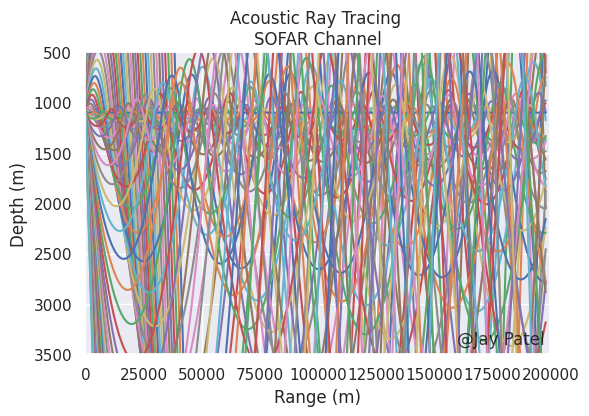

In [28]:
duration_sec = 2
dpi = 100
bitrate = 100

fig, ax = plt.subplots(dpi=dpi)
fig.text(0.89, 0.14, '@Crimson',
             fontsize=12, color='black',
             ha='right', va='bottom', alpha=0.75)
fps = len(SIMULATION_RANGE) // duration_sec

GifWriter = animation.ImageMagickFileWriter(fps,
                                             bitrate=bitrate
                                             )
save_filename = 'SOFAR_ray_trace_1.gif'
with GifWriter.saving(fig, save_filename, dpi=dpi):
    for i in range(0, len(SIMULATION_RANGE) + 75, 75):
        plt.cla()
        ax.set_xlim(0, SIMULATION_RANGE[-1])
        ax.set_ylim(500, 3500)
        ax.set_title(f"Acoustic Ray Tracing \nSOFAR Channel")
        plt.gca().invert_yaxis()
        plt.xlabel('Range (m)')
        plt.ylabel('Depth (m)')
        for a in range(0, len(TRANSMISSION_ANGLE_RANGE)):
            ax.plot(SIMULATION_RANGE[:i], z[a,:i])
        GifWriter.grab_frame()
plt.close()

![SegmentLocal](SOFAR_ray_trace_1.gif "segment")

# Reference 
1. https://brentonmallen.com/posts/underwater-acoustic-ray-tracing/